In [60]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker

## Plotting VaR and CVaR

In [61]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [62]:
def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                pareto_front.append({
                    "weights": solution.get("weights", []),
                    "expected_return": solution.get("expected_return", 0),
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": solution.get("period", [])
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)

In [63]:
def average_weights_pareto_fronts(pareto_fronts):
    averaged_pareto_fronts = []

    for pareto_front in pareto_fronts:
        # Extract all weights from the solutions in the Pareto front
        all_weights = np.array([solution["weights"] for solution in pareto_front])
        
        if len(all_weights) > 0:  # Ensure there are solutions to average
            # Compute the average weights
            avg_weights = np.mean(all_weights, axis=0)
        else:
            avg_weights = []

        # Create a new Pareto front with averaged weights
        averaged_pareto_front = []
        solution = pareto_front[0]
        new_solution = solution.copy()
        new_solution["weights"] = avg_weights.tolist()  # Convert numpy array back to list
        averaged_pareto_front.append(new_solution)
        
        averaged_pareto_fronts.append(averaged_pareto_front)

    return averaged_pareto_fronts


In [64]:
pareto_fronts = average_weights_pareto_fronts(pareto_fronts)

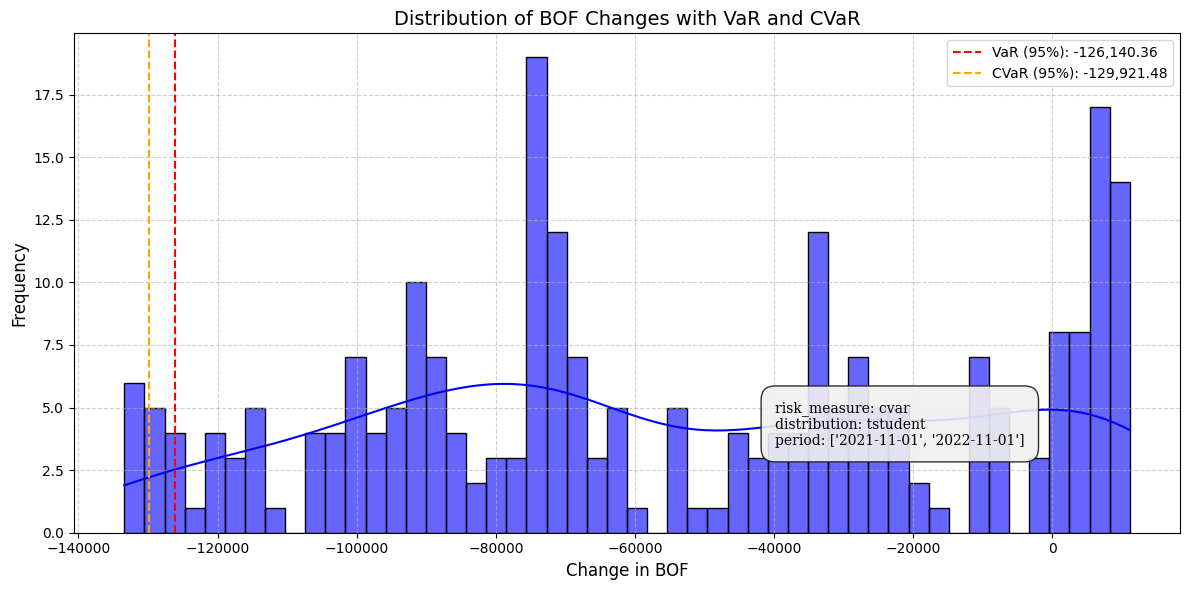

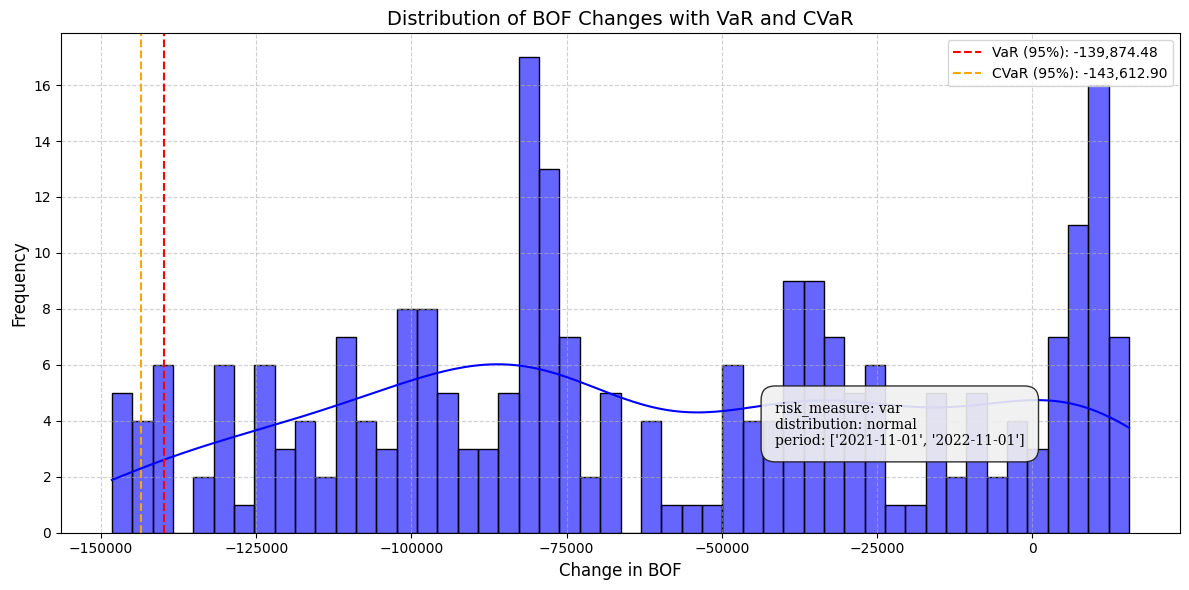

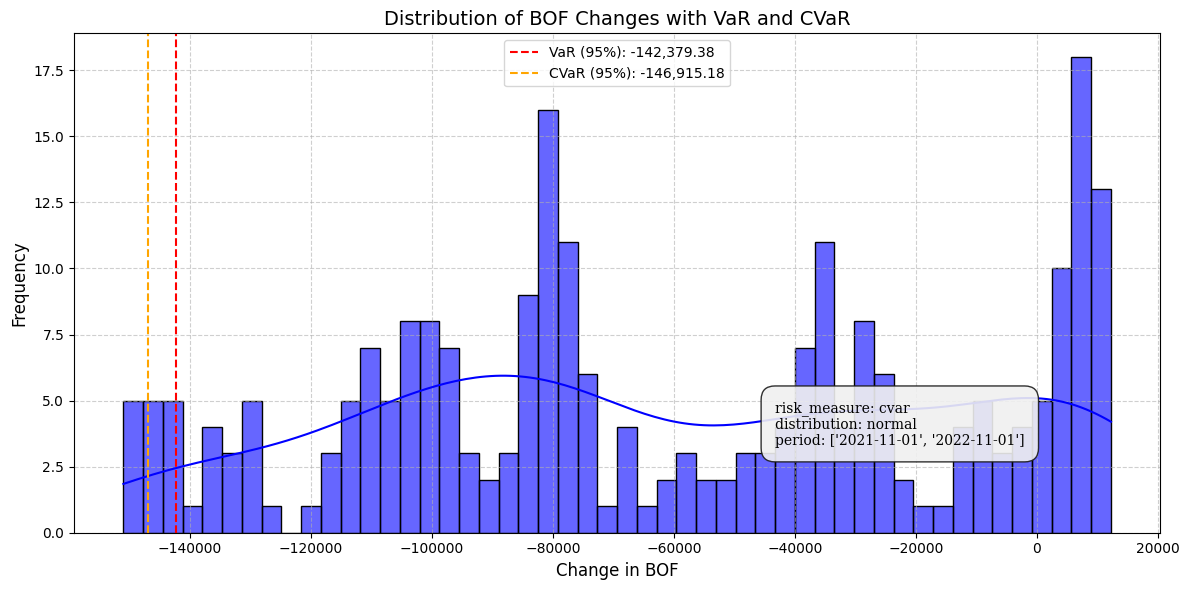

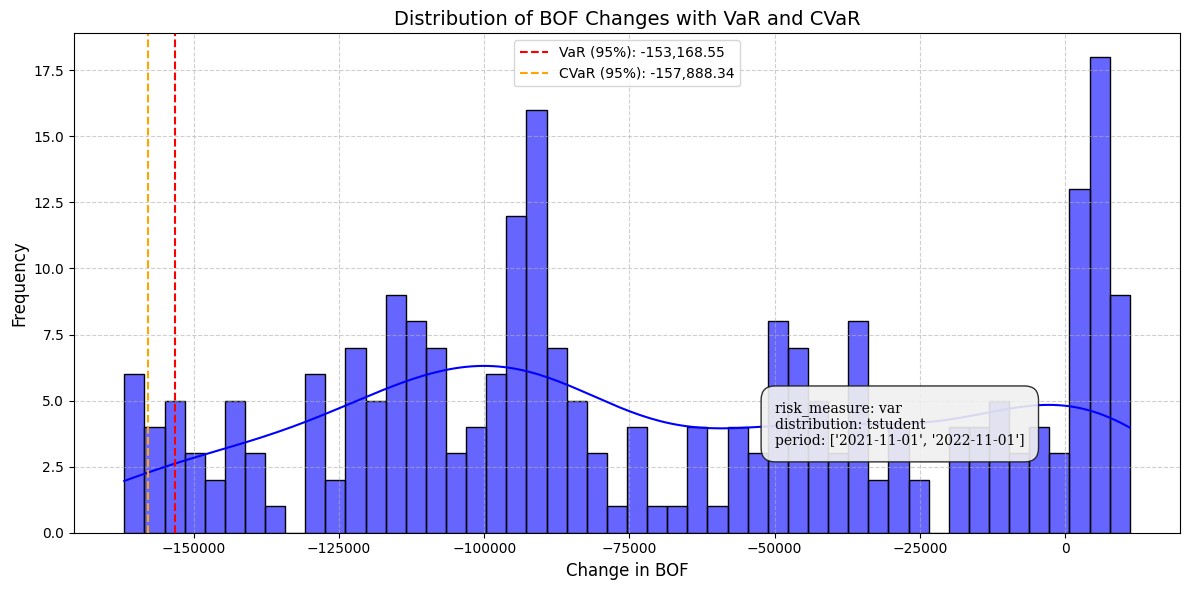

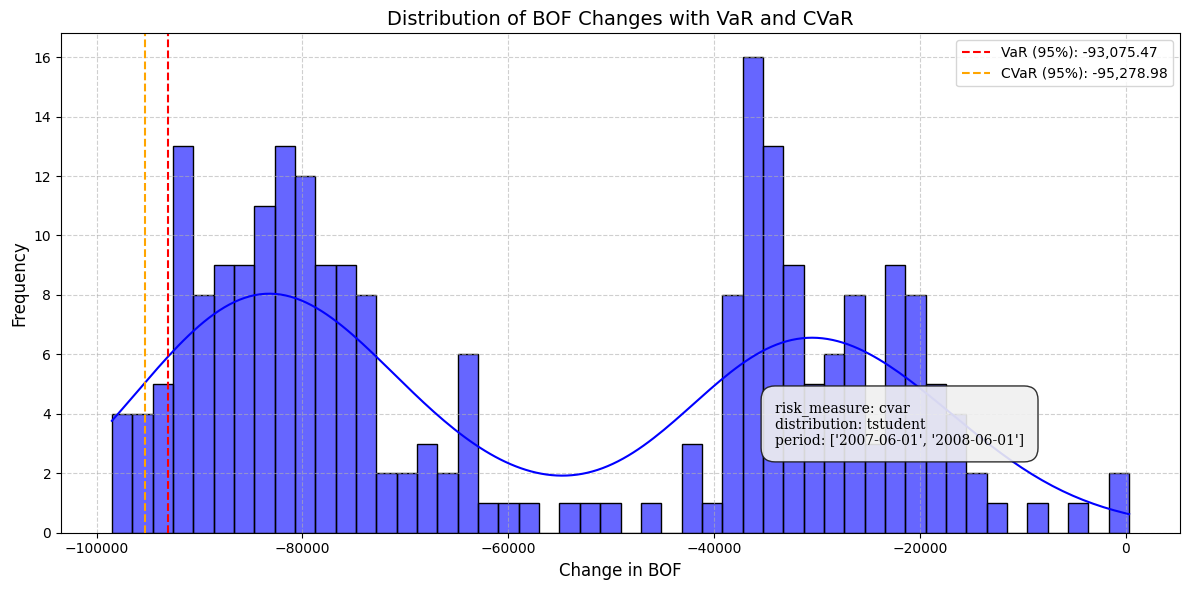

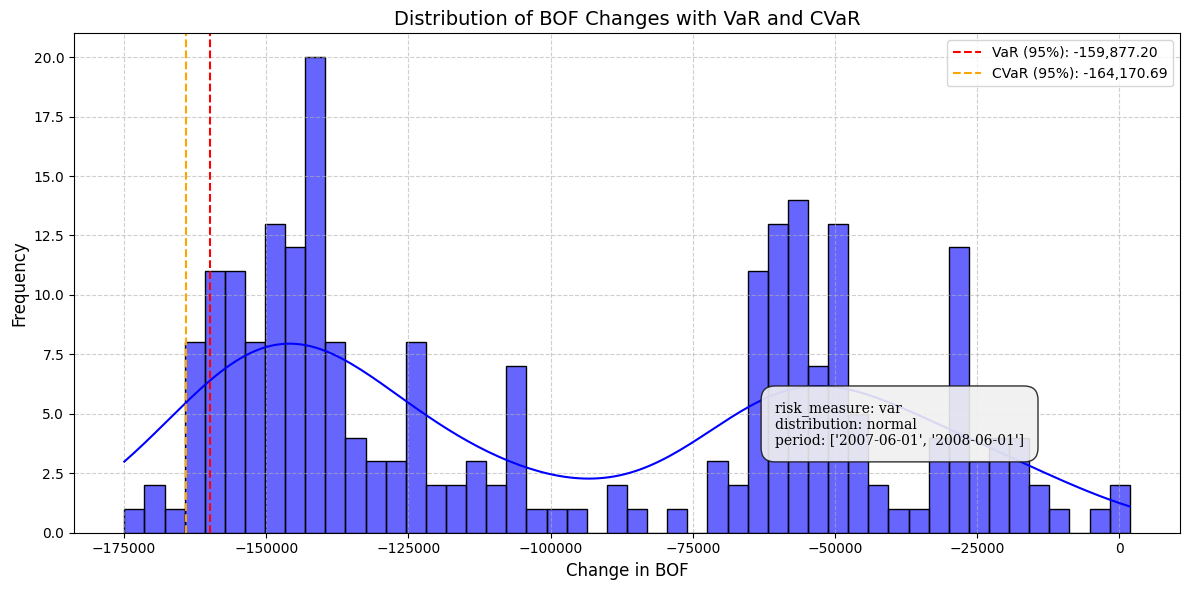

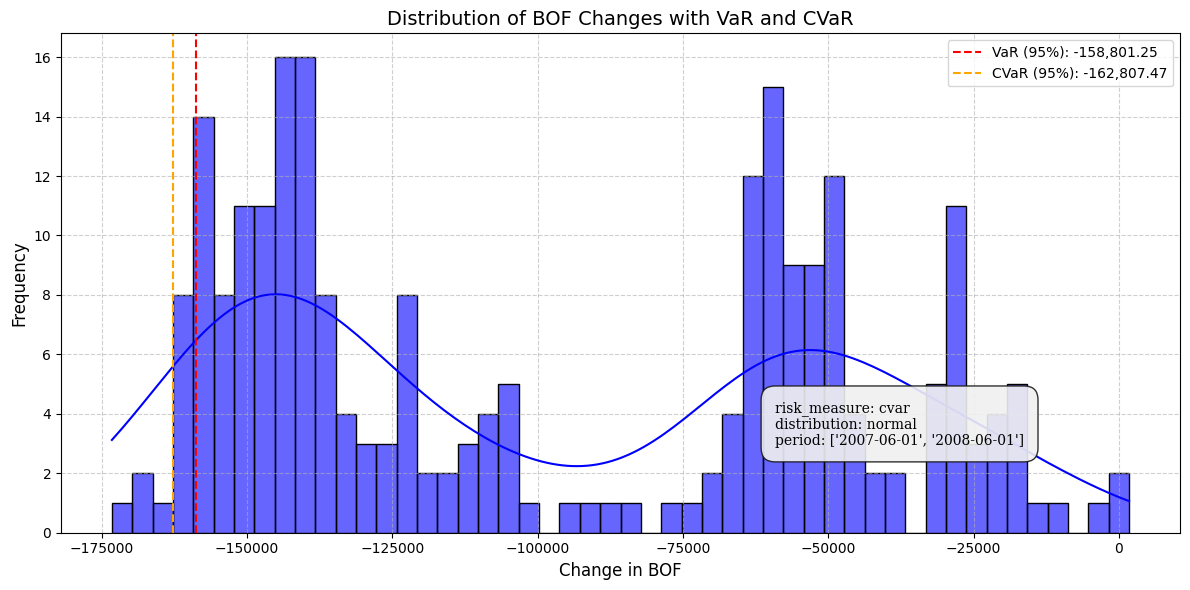

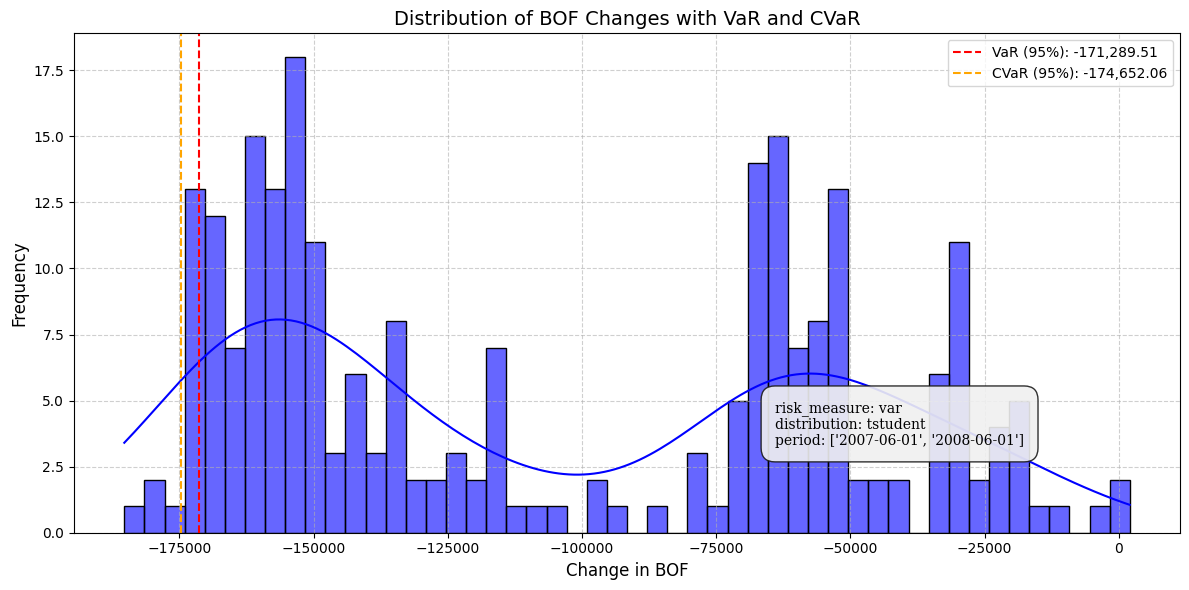

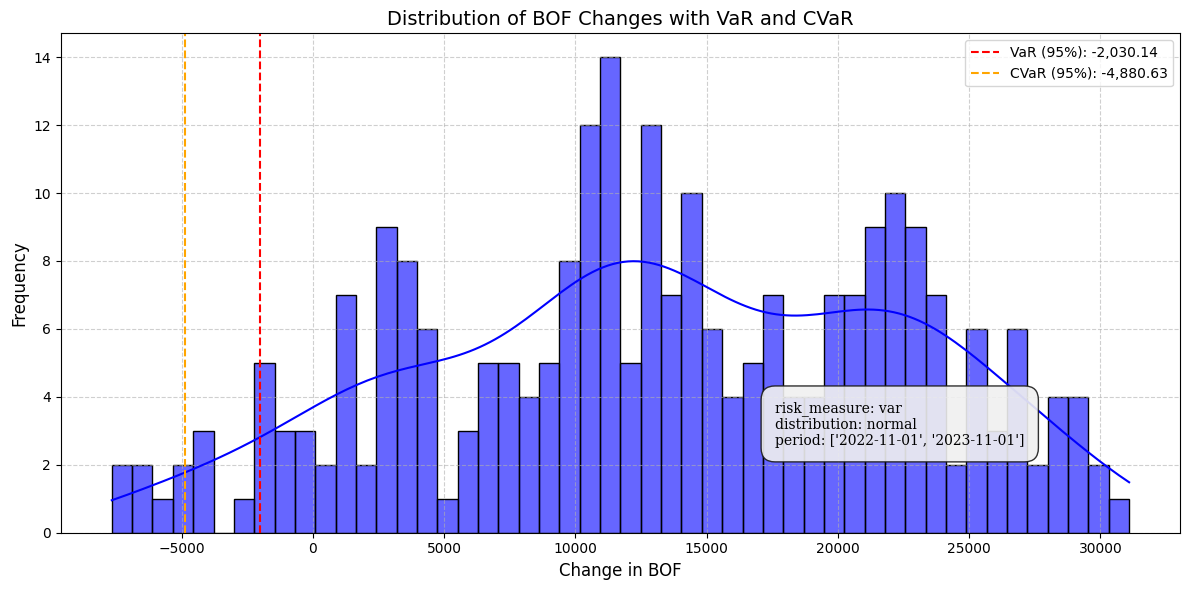

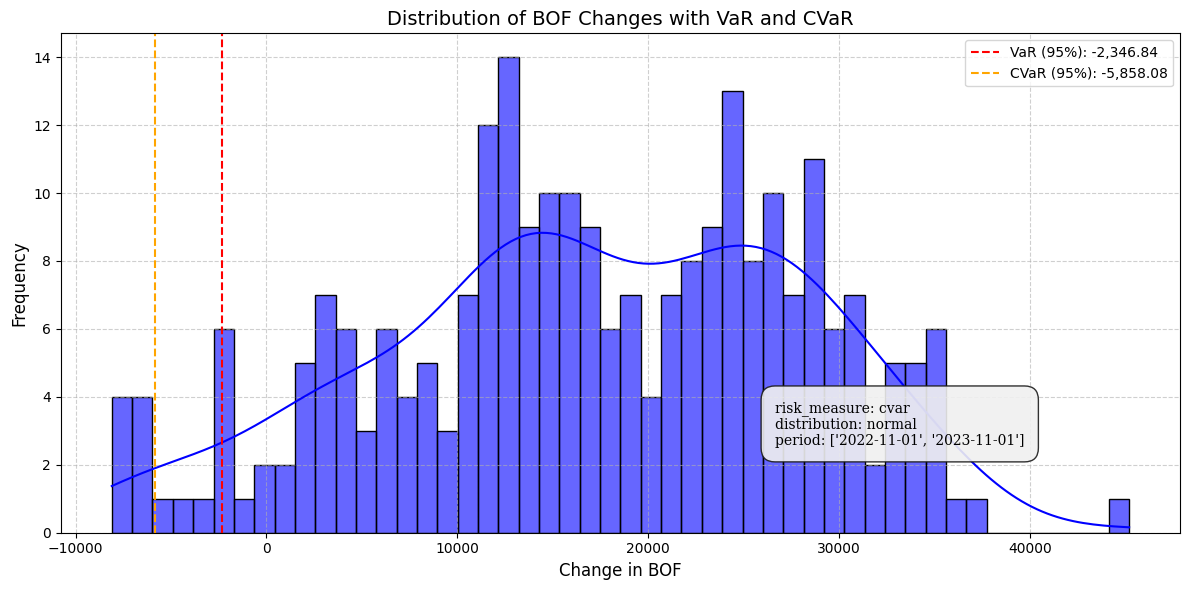

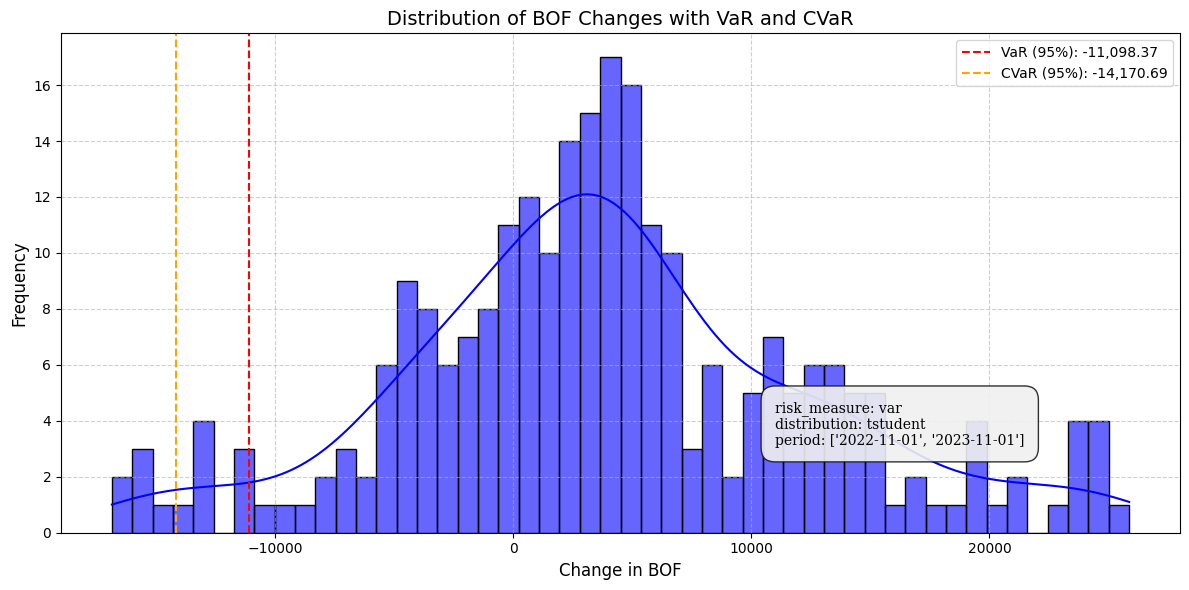

In [65]:
for pareto_front in pareto_fronts:
    for portfolio in pareto_front:
        bof_changes = []

        weights = portfolio["weights"]
        period = portfolio["period"]
        start_date = pd.to_datetime(period[0], format='%Y-%m-%d', errors='coerce')
        end_date = pd.to_datetime(period[1], format='%Y-%m-%d', errors='coerce')

        # Filter data for this period
        filtered_df = df[(df.index >= str(start_date)) & (df.index <= str(end_date))]
        
        assets_0 = 1000000
        liabilities_0 = assets_0 * 0.7

        # Loop over each day in the filtered period
        for current_date in filtered_df.index:
            # Filter data up to the current date
            current_data = filtered_df.loc[:current_date]

            # Calculate cumulative returns for the portfolio
            stock_returns = current_data
            eonia_returns = current_data["EONIA"]
            portfolio_returns = np.dot(stock_returns.values, weights)
            cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1

            # Calculate cumulative liability growth
            cumulative_liability_growth = np.prod(1 + eonia_returns) - 1

            # Calculate BOF change
            change_in_bof = (cumulative_portfolio_return * assets_0) - (cumulative_liability_growth * liabilities_0)

            # Append BOF change for each day
            bof_changes.append({
                "time": current_date,
                "final_bof": change_in_bof,
                "risk_measure": portfolio["risk_measure"]
            })
        info_text = "\n".join([f"{key}: {value}" for key, value in portfolio.items() if key not in ["weights", "expected_return", "SCR_risk"]])
        bof_changes_df = pd.DataFrame(bof_changes)
        confidence_level = 0.95
        VaR = np.percentile(bof_changes_df["final_bof"], 100 * (1 - confidence_level))
        CVaR = bof_changes_df[bof_changes_df["final_bof"] <= VaR]["final_bof"].mean()
        # Plot the distribution with more bins for thinner boxes
        plt.figure(figsize=(12, 6))
        sns.histplot(
            bof_changes_df["final_bof"], kde=True, bins=50, color="blue", alpha=0.6, edgecolor="black"
        )
        plt.axvline(VaR, color="red", linestyle="--", label=f"VaR (95%): {VaR:,.2f}")
        plt.axvline(CVaR, color="orange", linestyle="--", label=f"CVaR (95%): {CVaR:,.2f}")

        # Add annotations and style
        plt.title("Distribution of BOF Changes with VaR and CVaR", fontsize=14)
        plt.xlabel("Change in BOF", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()

        plt.gcf().text(
            0.65, 0.25, info_text, fontsize=10, fontfamily='serif',
            bbox=dict(
                facecolor='#f0f0f0',  # Light grey background
                edgecolor='#1a1a1a',  
                boxstyle='round,pad=1.0', alpha=0.9
            )
        )

plt.show()